추가할 내용
1. 챗봇 페르소나 정해주기
2. 사용자 인식하기 (그냥 db 말고 json으로 박자)
3. 검색하는 부분 고려 (이전 대화 얼만큼 볼것인가 .. 이런부분)

In [1]:
from modules.__init__ import *

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
LIMIT_LENGTH = 8
SEARCH_RETRY_COUNT = 5
SEARCH_RESULT_COUNT = 4
SEARCH_MINIMUM_RESULT = 1
system_prompt = prompt_config.system_message

In [3]:
llm = ChatOpenAI(model="gpt-4o")

class State(MessagesState):
    is_search: str
    is_personal: str
    is_preference: str
    
def _get_memory(namespace, 
                key,
                store:BaseStore):
    """
        Des:
            현재 저장된 사용자 정보를 가져오는 함수
    """
    existing_memory = store.get(namespace=namespace,
                                key=key)
    return existing_memory.value.get('memory') if existing_memory else ""

In [9]:
@trace_function(enable_print=False, only_func_name=True)
def _node_decide_personal(state: State):
    """
        Des:
            개인정보 여부가 있는지 판단하는 노드
    """
    query = state["messages"][-1].content
    prompt = [SystemMessage(content=prompt_config.decide_personal_prompt)] + [HumanMessage(content=query)]
    return {"is_personal":[llm.invoke(prompt)][0].content.upper()}

@trace_function(enable_print=False, only_func_name=True)
def _node_decide_preference(state: State):
    """
        Des:
            답변 선호도 여부가 있는지 판단하는 노드
    """
    query = state["messages"][-1].content
    prompt = [SystemMessage(content=prompt_config.decide_preference_prompt)] + [HumanMessage(content=query)]
    return {"is_preference":[llm.invoke(prompt)][0].content.upper()}

@trace_function(enable_print=False, only_func_name=True)
def _node_decide_search(state: State):
    """
        Des:
            검색 여부를 결정하는 노드
    """
    query = state["messages"][-1].content
    prompt = [SystemMessage(content=prompt_config.decide_search_prompt)] + [HumanMessage(content=query)]
    return {"is_search":[llm.invoke(prompt)][0].content.upper()}

@trace_function(enable_print=False, only_func_name=True)
def _node_write_memory(state: State, 
                        config: RunnableConfig, 
                        store: BaseStore):
    """
        Des:
            사용자 메시지를 인식하고, 개인정보/선호도/검색결과 등을 저장하는 노드
    """
    query = state["messages"][-1].content
    namespace = ("memories", config["configurable"]["user_id"])
    
    # 개인정보 판단 및 저장
    if state.get("is_personal") == "YES":
        personal_memory = _get_memory(namespace=namespace, 
                                            key="personal_info", 
                                            store=store)
        system_message = prompt_config.create_memory_prompt.format(memory=personal_memory)
        # print(f"{RED}Write Memory system_message : {system_message}{RESET}")
        memory_prompt = [SystemMessage(content=system_message)] + [HumanMessage(content=query)]
        store.put(namespace=namespace, 
                    key="personal_info", 
                    value={"memory":llm.invoke(memory_prompt).content})    
    if state.get("is_preference") == "YES":
        preference_memory = _get_memory(namespace=namespace, 
                                            key="personal_preference", 
                                            store=store)
        system_message = prompt_config.create_preference_prompt.format(preference=preference_memory)
        # print(f"{RED}Create Preference system_message : {system_message}{RESET}")
        preference_prompt = [SystemMessage(content=system_message)] + [HumanMessage(content=query)]
        store.put(namespace=namespace, 
                    key="personal_preference", 
                    value={"memory":llm.invoke(preference_prompt).content})

    if state.get("is_search") == "YES":
        main_context, suffix_context = web_search(query)
        store.put(namespace=namespace, 
                    key="main_context", 
                    value={"memory":main_context})
        store.put(namespace=namespace, 
                    key="suffix_context", 
                    value={"memory":suffix_context})
        
        
@trace_function(enable_print=False, only_func_name=True)
def web_search(query):
    prompt = prompt_config.generate_search_info.format(query=query)
    search_info = llm.invoke(prompt).content
    for _ in range(SEARCH_RETRY_COUNT):
        results = google_search_scrape(search_info, num_results=SEARCH_RESULT_COUNT)
        if len(results) >= SEARCH_MINIMUM_RESULT:
            break
    print(f"{RED}검색어 : {search_info}\n검색결과 : {len(results)}\n{RESET}")
    main_context = ''
    suffix_context = ''
    for idx, result in enumerate(results):
        link = result.get("link")
        try:
            desc, detailed_content = extract_content(link)
        except:
            pass
        try:
            if "Enable JavaScript and cookies" in detailed_content: # TODO 동적페이지 처리방식 필요
                continue
        except:
            continue
        main_context += f"제목 : {result.get('title')}\n링크 : {link}\n설명 : {desc}\n내용 : {detailed_content}\n\n"    
        suffix_context += f"""
📌 참고내용 [{idx+1}]
제목 : {result.get('title')}
링크 : {link}
설명 : {desc}
"""
    return main_context, suffix_context
    
@trace_function(enable_print=False, only_func_name=True)
def _node_answer(state: State, 
                 config: RunnableConfig,
                 store: BaseStore):
    """
        Des:
            사용자 메시지를 인식하고, 답변을 생성하는 노드
    """
    namespace = ("memories", config["configurable"]["user_id"])
    personal_memory = _get_memory(namespace=namespace, 
                                  key="personal_info", 
                                  store=store)
    personal_preference = _get_memory(namespace=namespace, 
                                            key="personal_preference", 
                                            store=store)

    if state.get("is_search") == "YES":
        main_context = _get_memory(namespace=namespace, 
                                key="main_context", 
                                store=store)
        suffix_context = _get_memory(namespace=namespace, 
                                    key="suffix_context", 
                                    store=store)
        system_message = prompt_config.answer_prompt.format(memory=personal_memory,
                                                            preference=personal_preference)
        user_prompt = prompt_config.answer_with_context.format(context=main_context,
                                                               query=state['messages'][-1].content)
        prompt = [SystemMessage(content=system_prompt+system_message)] + [HumanMessage(content=user_prompt)]
        print(f"{BLUE}Answer with Search prompt : {prompt[0].content}{RESET}")
        return {"messages": llm.invoke(prompt).content + "\n" + suffix_context}
    else:    
        system_message = prompt_config.answer_prompt.format(memory=personal_memory,
                                                            preference=personal_preference)
        prompt = [SystemMessage(content=system_prompt+system_message)] + state["messages"]
        print(f"{BLUE}Answer prompt : {prompt[0].content}{RESET}")
        return {"messages": llm.invoke(prompt)}

@trace_function(enable_print=False, only_func_name=True)
def _node_optimize_memory(state: State):
    """
        Des:
            메모리 최적화 함수
    """
    if len(state["messages"]) > LIMIT_LENGTH:
        delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:LIMIT_LENGTH//2]]
        return {"messages": delete_messages}
    else:
        return {"messages": state["messages"]}

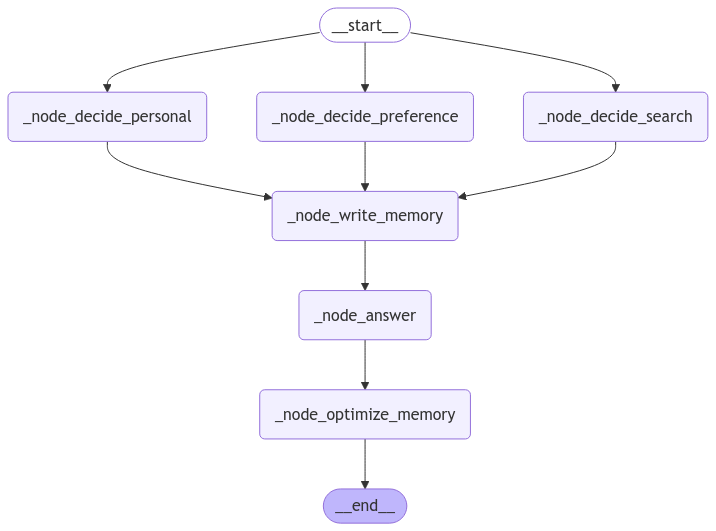

In [5]:
from IPython.display import Image, display
builder = StateGraph(State)
builder.add_node("_node_decide_personal", _node_decide_personal)
builder.add_node("_node_decide_preference", _node_decide_preference)
builder.add_node("_node_decide_search", _node_decide_search)
builder.add_node("_node_write_memory", _node_write_memory)
builder.add_node("_node_answer", _node_answer)
builder.add_node("_node_optimize_memory", _node_optimize_memory)
builder.add_edge(START, "_node_decide_personal")
builder.add_edge(START, "_node_decide_preference")
builder.add_edge(START, "_node_decide_search")
builder.add_edge(["_node_decide_personal", "_node_decide_preference", "_node_decide_search"], "_node_write_memory")
builder.add_edge("_node_write_memory", "_node_answer")
builder.add_edge("_node_answer", "_node_optimize_memory")
builder.add_edge("_node_optimize_memory", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
ShortTermMemory = MemorySaver()
LongTermMemory = InMemoryStore()
graph = builder.compile(checkpointer=ShortTermMemory,
                                store=LongTermMemory)

In [10]:
web_search("오늘 날씨 알려줘")

검색어 : "2025년 1월 10일 한국 날씨"
검색결과 : 0



('', '')

In [12]:
results = google_search_scrape("오늘 날씨 알려줘", num_results=SEARCH_RESULT_COUNT)
results

[{'title': '부산지방기상청', 'link': 'https://busan.kma.go.kr/'},
 {'title': '현재 날씨', 'link': 'https://www.weather.go.kr/w/weather/now.do'},
 {'title': '기상청 날씨누리: 홈', 'link': 'https://www.weather.go.kr/'},
 {'title': '단기예보',
  'link': 'https://www.kma.go.kr/w/weather/forecast/short-term.do'}]

In [17]:
desc, detailed_content = extract_content(results[1].get("link"))
desc

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  5.99it/s]


''

In [18]:
loader = AsyncHtmlLoader("https://www.weather.go.kr/w/weather/now.do")
docs = loader.load()
html2text = Html2TextTransformer()
docs_transformed = html2text.transform_documents(docs,metadata_type="html")
desc = docs_transformed[0].metadata.get('description',"")
detailed_content = docs_transformed[0].page_content

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  4.20it/s]


In [19]:
docs_transformed

[Document(metadata={'source': 'https://www.weather.go.kr/w/weather/now.do', 'title': '현재 날씨 - 기상청 날씨누리', 'language': 'ko'}, page_content='메인메뉴 바로가기 본문 바로가기\n\n# 기상청 날씨누리\n\n홈 바로가기\n\nKOR\n\nENG CHN JPN\n\n  * 날씨 __\n    * 기상특보 __\n      * 특보현황\n      * 통보문\n      * 영향예보\n      * 안개정보\n      * 날씨상황판\n    * 예보 __\n      * 단기예보\n      * 중기예보\n      * 북한날씨\n    * 기상방송 __\n  * 바다 __\n    * 해상특보 __\n    * 바다예보 __\n      * 일일예보\n      * 중기예보\n    * 바다예측 __\n      * 바다실황·예측\n      * 해구별예측\n      * 이안류 예측정보\n      * 너울 예측정보\n    * 해양일기도 __\n      * 수치파랑\n      * 폭풍해일\n      * 해양순환\n    * 해양기상정보포털 __\n  * 영상·일기도 __\n    * 날씨지도 __\n    * 종합영상 __\n    * 초단기예측 __\n      * 강수\n      * 바람\n    * 레이더 __\n    * 위성 __\n      * 천리안위성 2A호\n      * ASCAT\n      * 사례영상\n    * 낙뢰 __\n    * 일기도 __\n      * 분석일기도\n      * 예상일기도\n      * 전문가용일기도\n      * 바다수온\n    * 어는비 __\n  * 태풍 __\n    * 상세정보 __\n    * 통보문 __\n    * 위험시점정보 __\n    * 모델예측 __\n    * 태풍감시 __\n    * 과거태풍 __\n    * 태풍발생통계 __\n    * 기본지식 __\n     

In [7]:
messages = "오늘 날씨 알려줘"
graph.invoke({"messages": messages}, config={"configurable": {"thread_id": "default","user_id": "default"}})

검색어 : "2025년 1월 10일 서울 날씨"
검색결과 : 0

Answer with Search prompt : 당신의 이름은 '미네르바'이고 카카오톡에서 활동하는 챗봇입니다. 'ccw'님이 관리하고 있는 챗봇입니다. 

아래 지침 사항 3가지는 무조건 따르세요.
1. Markdown 형식(예: **, *, _)을 사용하지 마세요.
2. 텍스트 스타일(예: italic, bold)을 사용하지 마세요.
3. 내용이 길 경우 Bullet Point List 형태로 이해하기 쉽게 출력하세요.
당신은 사용자 요청에 대해 답변을 수행하는 유용한 챗봇입니다.

아래 [사용자 정보]와 [사용자 답변 선호도]를 참고해서 답변을 수행하세요.

[사용자 정보]:


[사용자 답변 선호도]:
죄송하지만, 실시간 데이터에 접근할 수 없어 현재 날씨 정보를 제공할 수 없습니다. 대신 지역의 기상 웹사이트나 날씨 앱을 확인해보시는 것을 추천드립니다.

답변:


{'messages': [HumanMessage(content='오늘 날씨 알려줘', additional_kwargs={}, response_metadata={}, id='62867fd3-70d2-4eaf-bb10-d360fd9c6a73'),
  HumanMessage(content='죄송하지만, 실시간 데이터에 접근할 수 없어 현재 날씨 정보를 제공할 수 없습니다. 대신 지역의 기상 웹사이트나 날씨 앱을 확인해보시는 것을 추천드립니다.\n', additional_kwargs={}, response_metadata={}, id='2ceb0423-0d11-4f44-9e82-65a3220cc681')],
 'is_search': 'YES',
 'is_personal': 'NO',
 'is_preference': 'YES'}